In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats
import random
import time
from matplotlib.gridspec import GridSpec

In [2]:
'''


obj_cam_space = [x_c, y_c, z_c, 1]

c2w = [[rf_11, rf_12, rf_13, rf_14],
       [rf_21, rf_22, rf_23, rf_24],
       [rf_31, rf_32, rf_33, rf_34],
       [rf_41, rf_42, rf_43, rf_44],]

obj_world_space = [x_w, y_w, z_w, 1] = c2w * obj_cam_space

x_w = rf_11*x_c + rf_12*y_c + rf_13*z_c + rf_14*1
y_w = rf_21*x_c + rf_22*y_c + rf_23*z_c + rf_14*1
z_w = rf_31*x_c + rf_32*y_c + rf_33*z_c + rf_14*1

'''
def get_transformatrix(cam_poses):
    
    c2w = np.zeros((4,4,3))
    for i in range(3): # Cam 1, 2, 3
        
        cx = cam_poses[i,0]
        cy = cam_poses[i,1]
        cz = cam_poses[i,2]
        alpha = cam_poses[i,3]
        beta = cam_poses[i,4] 
        gamma = cam_poses[i,5]

        # Transformation matrices (translation + rotations around x, y, z)
        mat_tran = np.array([[1,0,0,cx],
                             [0,1,0,cy],
                             [0,0,1,cz],
                             [0,0,0,1]])

        mat_rotx = np.array([[1,0,0,0],
                             [0,math.cos(alpha), -math.sin(alpha),0],
                             [0, math.sin(alpha), math.cos(alpha),0],
                             [0,0,0,1]])

        mat_roty = np.array([[math.cos(beta), 0, math.sin(beta),0],
                             [0,1,0,0],
                             [-math.sin(beta), 0, math.cos(beta),0],
                             [0,0,0,1]])


        mat_rotz = np.array([[math.cos(gamma), -math.sin(gamma), 0, 0],
                             [math.sin(gamma), math.cos(gamma),0, 0],
                             [0,0,1,0],
                             [0,0,0,1]])

        # General transformation matrix 'camera to world' (c2w)
        c2w[:,:,i] = mat_tran.dot(mat_rotx).dot(mat_roty).dot(mat_rotz)
    
    
    return c2w



'''

if X ~ N[mu_x, sigma_x^2] then:
    (a*X + b) ~ N[a*mu_x+b, (a*sigma_x)^2]

if X ~ N[mu_x, sigma_x^2] and Y ~ N[mu_y, sigma_y^2] and Z ~N[mu_z, sigma_z^2] are independent, then:
    X+Y+Z ~ N[mu_x+mu_y+mu_z, sigma_x^2+sigma_y^2+sigma_z^2]

x_w ~ N[rf_11*mu_x_c + rf_12*mu_y_c + rf_13*mu_z_c + rf_14, (rf_11*sigma_x_c)^2 +(rf_12*sigma_y_c)^2 + (rf_13*sigma_z_c)^2]
y_w ~ N[rf_21*mu_x_c + rf_22*mu_y_c + rf_23*mu_z_c + rf_24, (rf_21*sigma_x_c)^2 +(rf_22*sigma_y_c)^2 + (rf_23*sigma_z_c)^2]
z_w ~ N[rf_31*mu_x_c + rf_32*mu_y_c + rf_33*mu_z_c + rf_34, (rf_31*sigma_x_c)^2 +(rf_32*sigma_y_c)^2 + (rf_33*sigma_z_c)^2]

'''  

def get_world_gaussian(mu_c, sigma_c, c2w):
    
    mu_w = np.zeros((3,5))
    sigma_w = np.zeros((3,5))
    
    for i in range(3): # Cam 1, 2, 3
        for j in range(3):
            mu_w[j, i] = c2w[j,0,i]*mu_c[0,i] + c2w[j,1,i]*mu_c[1,i] + c2w[j,2,i]*mu_c[2,i] + c2w[j,3,i]
            sigma_w[j, i] = math.sqrt((c2w[j,0,i]*sigma_c[0,i])**2 +(c2w[j,1,i]*sigma_c[1,i])**2 + (c2w[j,2,i]*sigma_c[2,i])**2)
        
    return mu_w, sigma_w


'''
This function generates ARTIFICIAL statistics (mean and std) for 'nb_pts' observations using one instrument
The purpose of this function is to 'simulate' what the validation does after SNN training
During validation, knowing ground truth, it is possible to estimate how far away predictions and reality are
Parameter 'k' should be smaller than 1 (usually 0.1 or less) since it indicates prediction error
'''
def generate_snn_stats(nb_pts, k):
    
    
    max_val = 1
    min_val = -1
    abs_max_err = (max_val-min_val)*k
    
    array_true = np.random.uniform(low=min_val, high=max_val, size=(nb_pts,))
    array_snn = np.zeros(nb_pts)
    
    for idx in range(len(array_true)):
        
        err = abs_max_err* np.random.randint(-1, high=1, size=(1,))
        array_snn[idx] = array_true[idx]*(1 + err)


    error = array_true-array_snn

    std = np.std(error)
    std = k
    mean = np.mean(error)
    mean = 0
        
    return mean, std


'''
The product of 3 gaussian PDFs is a gaussian PDF
This function estimates the mu and sigma of such gaussian
It also return the PDF for a given array of values

Inputs: 
 - values: array of float between 0 and 1 
 - mu: array of means (from N 'observations' using three instruments: cam 1, 2, 3)
 - sigma: array of stds (from N 'observations' using three instruments: cam 1, 2, 3)
 
 Outputs:
 - pdf_123: probability distribution obtained from three instruments 
 - mu_123: mean of pdf_123
 - sigma_123: std of pdf_123
 
'''
def get_product(values, mu, sigma):
    
    mu_1 = mu[0]
    mu_2 = mu[1]
    mu_3 = mu[2]
    
    ss_1 = sigma[0]**2
    ss_2 = sigma[1]**2
    ss_3 = sigma[2]**2
    
    
    mu_123 = (ss_1*ss_2*mu_3 + ss_2*ss_3*mu_1 + ss_3*ss_1*mu_2)/(ss_3*ss_2 + ss_2*ss_1 + ss_1*ss_3)
    sigma_123 = math.sqrt((ss_1 * ss_2 * ss_3)/(ss_1*ss_2 + ss_2*ss_3 + ss_3*ss_1))
    
    
    pdf_123 = stats.norm.pdf(values, mu_123, sigma_123)
    
    return pdf_123, mu_123, sigma_123

'''
This function estimates how likely it is that a certain (x,y,z) is the true one
mu and sigma are arrays containing mean and std for x,y,z coordinates
The purpose of this function is to faciltiate visualization (not needed for pose merging)
'''
def get_joint(x, y, z, mu, sigma):
    
    p_x = np.exp(-((x-mu[0])**2)/(2*sigma[0]**2))/(sigma[0]*math.sqrt(2*math.pi))
    p_y = np.exp(-((y-mu[1])**2)/(2*sigma[1]**2))/(sigma[1]*math.sqrt(2*math.pi))
    p_z = np.exp(-((z-mu[2])**2)/(2*sigma[2]**2))/(sigma[2]*math.sqrt(2*math.pi))
    
        
    return p_x*p_y*p_z


'''
This function produces 9x2 parameters:mean and std for all combinations of camera/axis (1,2,3 * x,y,z)
Some values are hardcoded in 'e_per' to account for uncertainty for each axis (which depends on camera pose)
'''
def produce_snn_stats(nb_pts, e_per):
       
    
    cam_pdf_params = np.zeros((3,3,2)) # {1,2,3} | {x,y,z} | {mean, std}
    

    #Cam 1
    cam_pdf_params[0,0,:] = generate_snn_stats(nb_pts, e_per[0,0]) # x
    cam_pdf_params[0,1,:] = generate_snn_stats(nb_pts, e_per[0,1]) # y
    cam_pdf_params[0,2,:] = generate_snn_stats(nb_pts, e_per[0,2]) # z

    #Cam 2
    cam_pdf_params[1,0,:] = generate_snn_stats(nb_pts, e_per[1,0]) # x
    cam_pdf_params[1,1,:] = generate_snn_stats(nb_pts, e_per[1,1]) # y
    cam_pdf_params[1,2,:] = generate_snn_stats(nb_pts, e_per[1,2]) # z

    #Cam 3
    cam_pdf_params[2,0,:] = generate_snn_stats(nb_pts, e_per[2,0]) # x
    cam_pdf_params[2,1,:] = generate_snn_stats(nb_pts, e_per[2,1]) # y
    cam_pdf_params[2,2,:] = generate_snn_stats(nb_pts, e_per[2,2]) # z
    
    
    return cam_pdf_params

'''
This function defines ground truth (for a point in space)
'''
def define_object_pose(c2w, ground_truth):
    
    perspective = np.zeros((4,3)) # coordinates|cameras
    # Checking output of each camera
    for i in range(3): # Cam 1, 2, 3
        w2c = np.linalg.inv(c2w[:,:,i])
        perspective[:, i] = w2c.dot(ground_truth)

    return perspective[0:3,:]

'''
This function recenters gaussians (from SNN stats) around SNN values
SNN values are 'observations' of the ground truth done by the SNN through 3 cameras in camera space
Each Camera introduces some error (in addition to the one intrinsic to the SNN)
'''
def recenter_gaussians(nb_pts, perspective, cam_pdf_params):
    
    mu_c = np.zeros((3,5))
    sigma_c = np.zeros((3,5))
    snn_values = np.zeros((3,3)) # Represents the output of the SNN: cams 1, 2, 3 --> (x, y, z)  
    
    # intrinsec camera error (applies for all cameras)
    ice = np.array([0.001,0.001,0.001]) # x: 0.1% , y: 0.1%, z: 0.1%
    
    # Generating SNN values and recentering Gaussians (@ASK_JORG: is recentering needed?)
    for j in range(3): # x, y, z

        # Checking output of each camera
        for i in range(3): # Cam 1, 2, 3

            # Each camera behaves its own way: some error, vs ground truth, is expected in the 'snn_values' (<1%)
            snn_values[i,j] = perspective[j,i] + np.random.uniform(low=0.0, high=ice[j], size=(1,))

            # The Gaussians, from the SNN stats, are centered around the 'snn_values'
            mu_c[j,i] = snn_values[i,j] + cam_pdf_params[i,j,0]
            sigma_c[j,i] = cam_pdf_params[i,j,1]
    
    
    
    return mu_c, sigma_c


'''
For each axis, this function produces 3 'basic' PDFs (one per camera) plus 1 'special' PDF (from their product)
The function plots the 4 PDFs (in 3 subplots, one per axis) and returns 'xyz' and 'pdf'
'xyz' is the array of coordinates; 'pdf' is a matrix with the generated PDFs
'''
def generate_pdfs(nb_pts, pdf_center, mu, sigma):
    
    base_xyz = np.linspace(stats.norm.ppf(0.05), stats.norm.ppf(0.95), nb_pts)
    xyz = np.zeros((3,nb_pts))
    pdf = np.zeros((5,3,nb_pts))   
    
    
    # Generating PDFs (+ prodcuts and mixtures)
    for j in range(3): # x, y, z

        
        # This is done to re-center xyz array (for visual purposes)
        xyz[j,:] = base_xyz + pdf_center[j] 

        # Checking output of each camera
        for i in range(3): # Cam 1, 2, 3
      
            # PDF is calculated, using stats, with the purpose of visualization (not needed for pose merging)
            pdf[i,j,:] = stats.norm.pdf(xyz[j,:], mu[j,i], sigma[j,i]) 

        # Once PDFs for cameras 1,2,3 are estimated, their product is obtained. IMPORTANT: mu[j,3] and sigma[j,3] 
        pdf[3,j,:], mu[j,3], sigma[j,3] = get_product(xyz[j,:], mu[j,:], sigma[j,:]) 

    
    return xyz, pdf, mu, sigma


def data2text(ground_truth, cam_poses, mu_c, sigma_c, mu_w, sigma_w):
    
    text = ""
    text = text + "\n Object:\n"
    text = text + "\n    Pose:"
    text = text + "\n       x = %3.3f | y = %3.3f | z = %3.3f" %(ground_truth[0], ground_truth[1], ground_truth[2])
    for i in range(3):
        text = text + "\n\n Camera %d:\n" %(i+1)
        text = text + "\n    Pose:"
        text = text + "\n       x = %3.3f | y = %3.3f | z = %3.3f" %(cam_poses[i,0], cam_poses[i,1], cam_poses[i,2])
        text = text + "\n       alpha = %3.3f | beta = %3.3f | gamma = %3.3f" %(cam_poses[i,3], cam_poses[i,4], cam_poses[i,5])
        text = text + "\n    PDF:"
        text = text + "\n       Camera Space:"
        text = text + "\n          mu_x = %3.3f | mu_y = %3.3f | mu_z = %3.3f" %(mu_c[0,i], mu_c[1,i], mu_c[2,i])
        text = text + "\n          sigma_x = %3.3f | sigma_y = %3.3f | sigma_z = %3.3f" %(sigma_c[0,i], sigma_c[1,i], sigma_c[2,i])
        text = text + "\n       World Space:"
        text = text + "\n          mu_x = %3.3f | mu_y = %3.3f | mu_z = %3.3f" %(mu_w[0,i], mu_w[1,i], mu_w[2,i])
        text = text + "\n          sigma_x = %3.3f | sigma_y = %3.3f | sigma_z = %3.3f" %(sigma_w[0,i], sigma_w[1,i], sigma_w[2,i])
    
    text = text + "\n\n\n"
    
    print("The object is likely to be located at (%3.3f, %3.3f, %3.3f)" %(mu_w[0,3], mu_w[1,3], mu_w[2,3]))
    
    return text

def ultimate_plot(xyz, pdf, text, scenario):   
    fig = plt.figure(constrained_layout=True, figsize=(15,10))

    N = 5
    gs = GridSpec(3, 10, figure=fig)
    ax_t = fig.add_subplot(gs[:, 0:N])
    # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    ax_x = fig.add_subplot(gs[0,N:])
    ax_y = fig.add_subplot(gs[1,N:])
    ax_z = fig.add_subplot(gs[2,N:])


    # Text:

    ax_t.text(0.050,0.075,text, family='monospace')

    labels = ['Cam 1', 'Cam 2', 'Cam3', 'Prod', 'Mixt.']
    styles = ['-', '-', '-', '--']
    
    for k in range(3+1): # 1,2,3, product
        ax_x.plot(xyz[0,:], pdf[k,0,:], label=labels[k], linestyle = styles[k])
        ax_y.plot(xyz[1,:], pdf[k,1,:], label=labels[k], linestyle = styles[k])
        ax_z.plot(xyz[2,:], pdf[k,2,:], label=labels[k], linestyle = styles[k])


    max_pdf = pdf.max()
        
    ax_t.set_xticks([])
    ax_t.set_yticks([])

    
    ax_x.legend(bbox_to_anchor=(1.2, 0.65))   
    ax_y.legend(bbox_to_anchor=(1.2, 0.65))   
    ax_z.legend(bbox_to_anchor=(1.2, 0.65))   
    
    x_center = xyz[0,np.argmax(pdf[3,0,:])]
    y_center = xyz[1,np.argmax(pdf[3,1,:])]
    z_center = xyz[2,np.argmax(pdf[3,2,:])]
    
    delta = 0.7
    
    min_x = 0.1*int(10*(x_center-delta))
    max_x = 0.1*int(10*(x_center+delta))
    min_y = 0.1*int(10*(y_center-delta))
    max_y = 0.1*int(10*(y_center+delta))
    min_z = 0.1*int(10*(z_center-delta))
    max_z = 0.1*int(10*(z_center+delta))
    
    ax_x.set_xlim([x_center - delta, x_center + delta])
    ax_y.set_xlim([y_center - delta, y_center + delta])
    ax_z.set_xlim([z_center - delta, z_center + delta])
    ax_x.set_ylim([0, max_pdf])
    ax_y.set_ylim([0, max_pdf])
    ax_z.set_ylim([0, max_pdf])

    ax_x.set_xlabel('x')
    ax_y.set_xlabel('y')
    ax_z.set_xlabel('y')

    ax_x.set_xticks(np.arange(min_x, max_x, 0.1))
    ax_y.set_xticks(np.arange(min_y, max_y, 0.1))
    ax_z.set_xticks(np.arange(min_z, max_z, 0.1))

    fig.suptitle("Density of Probability for x, y, z corresponding to cameras 1, 2 and 3")
    
    plt.savefig("tests/scenario_" + str(scenario) + ".png", transparent=False)

    plt.show()


'''
This function produces 3 PDFs from SNN stats and one from the product of these
The function plots the PDFs (in 3 subplots, one per axis) and returns two arrays: mu and sigma
'''
def emulate_SNN_with_pose_transformation(nb_pts, cam_poses, ground_truth, e_per, scenario):

    c2w = get_transformatrix(cam_poses)
    
    # Define object pos: ground truth and as seen from each camera
    perspective = define_object_pose(c2w, ground_truth)
    
    # Get PDFs from SNN 'observations' (mu|sigma in camera space for each axis|camera)
    cam_pdf_params = produce_snn_stats(nb_pts, e_per)
    mu_c, sigma_c = recenter_gaussians(nb_pts, perspective, cam_pdf_params)  
    
    
    # Convert gaussians from camera space to world space and generate PDFs
    mu_w, sigma_w = get_world_gaussian(mu_c, sigma_c, c2w)
         
    xyz_w, pdf_w, mu_w, sigma_w = generate_pdfs(nb_pts, ground_truth, mu_w, sigma_w) 
    
    text = data2text(ground_truth, cam_poses, mu_c, sigma_c, mu_w, sigma_w)
    ultimate_plot(xyz_w, pdf_w, text, scenario)    
        
    # @TODO ... mu_w and sigma_w should be returned
    return mu_c, sigma_c, mu_w, sigma_w

'''
This function reconstructs a 3D representation of the probabilities of the actual (x,y,z) being somewhere in space
'''
def visualize_3d(nb_pts, mu, sigma):
    
    x = y = z = np.linspace(stats.norm.ppf(0.10), stats.norm.ppf(0.90), nb_pts) + np.mean(mu[:,3])

    # Getting joint probabilities
    start = time.time()
    p = np.zeros((nb_pts,nb_pts, nb_pts))
    for idx_x in range (nb_pts): # x, y, z
        for idx_y in range (nb_pts): # x, y, z
            for idx_z in range (nb_pts): # x, y, z   
                p[idx_x, idx_y, idx_z] = get_joint(x[idx_x], y[idx_y], z[idx_z], mu[:,3], sigma[:,3])

    stop = time.time()
    elapsed = stop - start
    print("Joint probabilities obtained after: " + str(int(elapsed)) + " seconds.")

    # Creating figure
    fig = plt.figure(figsize=(12,12))
    ax = plt.axes(projection="3d")

    idx = p > 0.5

    # Creating plot
    xx, yy, zz = np.meshgrid(x, y, z)
    ax.scatter3D(xx[idx], yy[idx], zz[idx], c=p[idx], cmap='viridis', vmin=0, vmax=10, marker='.')

    xs = np.linspace(-1, 1, nb_pts)
    ys = np.linspace(-1, 1, nb_pts)
    zs = np.linspace(-1, 1, nb_pts)

    X, Y = np.meshgrid(xs, ys)
    Z = np.ones((nb_pts,nb_pts))*mu[2,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    Y, Z = np.meshgrid(ys, zs)
    X = np.ones((nb_pts,nb_pts))*mu[0,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    X, Z = np.meshgrid(xs, zs)
    Y = np.ones((nb_pts,nb_pts))*mu[1,3]
    ax.plot_surface(Y, X, Z, alpha=0.2, color='k')

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('z')
    ax.set_xticks(np.linspace(-1, 1, 21))
    ax.set_yticks(np.linspace(-1, 1, 21))
    ax.set_zticks(np.linspace(-1, 1, 21))

    plt.show()  
    
     

In [3]:
scenario = 0

All cameras at the origin, same <mu|sigma>_<x|y|z> for all cameras
The object is likely to be located at (-0.300, 0.601, 0.500)


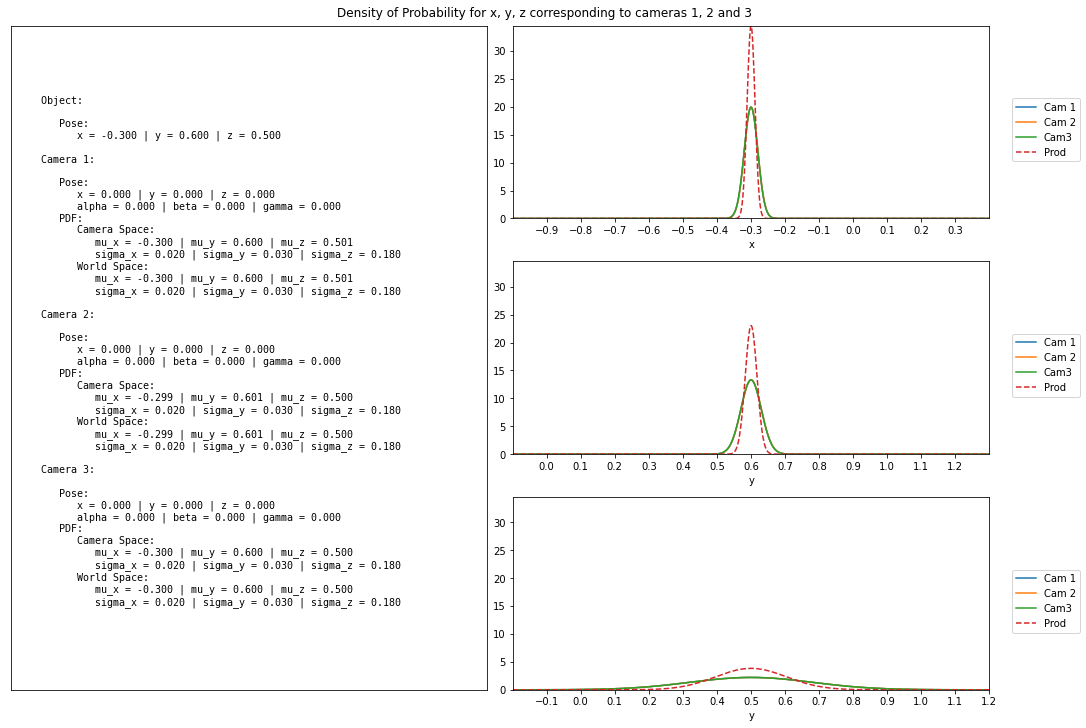

In [4]:

nb_pts = 2000

%matplotlib inline


cam_poses = np.zeros((3,6)) # 3 cameras, 6 parameters

# Cam 1
cam_poses[0,0] = 0 # cam1:cx
cam_poses[0,1] = 0 # cam1:cy
cam_poses[0,2] = 0 # cam1:cz
cam_poses[0,3] = (math.pi/180)*(0) # cam1:alpha
cam_poses[0,4] = (math.pi/180)*(0) # cam1:beta
cam_poses[0,5] = (math.pi/180)*(0) # cam1:gamma

# Cam 2
cam_poses[1,0] = 0 # cam2:cx
cam_poses[1,1] = 0 # cam2:cy
cam_poses[1,2] = 0 # cam2:cz
cam_poses[1,3] = (math.pi/180)*(0) # cam2:alpha
cam_poses[1,4] = (math.pi/180)*(0) # cam2:beta
cam_poses[1,5] = (math.pi/180)*(0) # cam2:gamma

# Cam 3
cam_poses[2,0] = 0 # cam3:cx
cam_poses[2,1] = 0 # cam3:cy
cam_poses[2,2] = 0 # cam3:cz
cam_poses[2,3] = (math.pi/180)*(0)# cam3:alpha
cam_poses[2,4] = (math.pi/180)*(0)# cam3:beta
cam_poses[2,5] = (math.pi/180)*(0)# cam3:gamma

# Object's pose
ground_truth = [-0.3, 0.6, 0.5, 1]

# Max error per camera/axis ([cam1[x, y, z], cam2[x, y, z], cam2[x, y, z]])
e_per = np.array([[0.02, 0.03, 0.18], [0.02, 0.03, 0.18], [0.02, 0.03, 0.18]]) 

print("All cameras at the origin, same <mu|sigma>_<x|y|z> for all cameras")
scenario += 1

mu_c, sigma_c, mu_w, sigma_w = emulate_SNN_with_pose_transformation(nb_pts, cam_poses, ground_truth, e_per, scenario)


All cameras with different (x, y, z) coordinates, same <mu|sigma>_<x|y|z> for all cameras
The object is likely to be located at (-0.300, 0.600, 0.500)


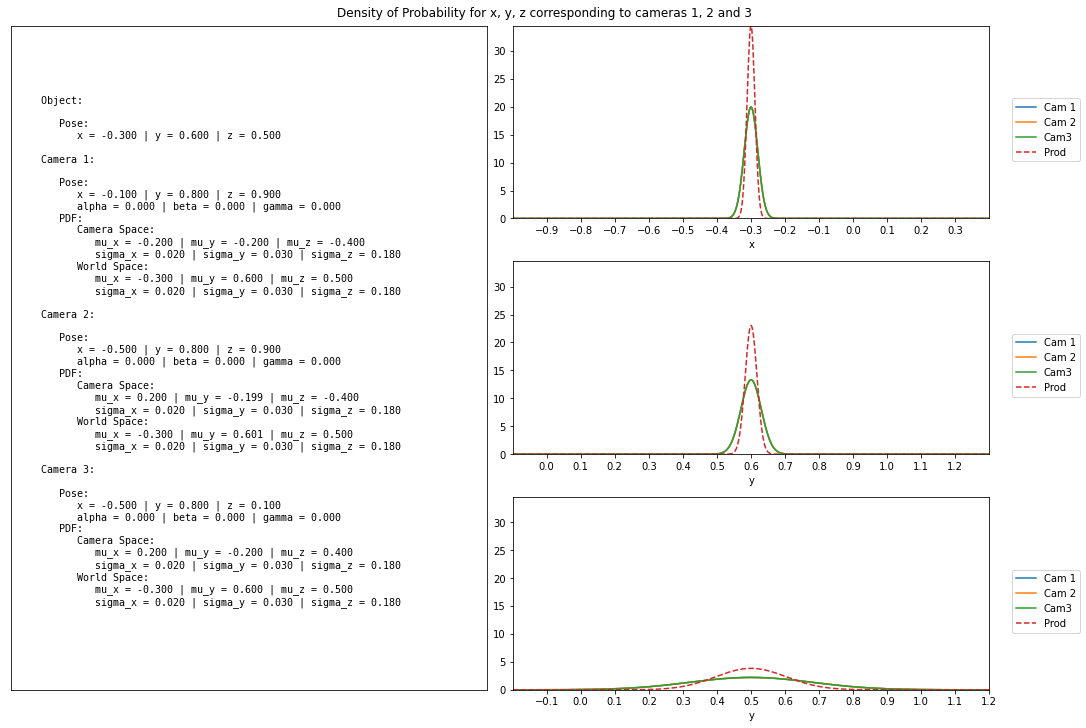

In [5]:

nb_pts = 2000

%matplotlib inline


cam_poses = np.zeros((3,6)) # 3 cameras, 6 parameters

# Cam 1
cam_poses[0,0] = -0.1 # cam1:cx
cam_poses[0,1] =  0.8 # cam1:cy
cam_poses[0,2] =  0.9 # cam1:cz
cam_poses[0,3] = (math.pi/180)*(0) # cam1:alpha
cam_poses[0,4] = (math.pi/180)*(0) # cam1:beta
cam_poses[0,5] = (math.pi/180)*(0) # cam1:gamma

# Cam 2
cam_poses[1,0] = -0.5 # cam2:cx
cam_poses[1,1] =  0.8 # cam2:cy
cam_poses[1,2] =  0.9 # cam2:cz
cam_poses[1,3] = (math.pi/180)*(0) # cam2:alpha
cam_poses[1,4] = (math.pi/180)*(0) # cam2:beta
cam_poses[1,5] = (math.pi/180)*(0) # cam2:gamma

# Cam 3
cam_poses[2,0] = -0.5 # cam3:cx
cam_poses[2,1] =  0.8 # cam3:cy
cam_poses[2,2] =  0.1 # cam3:cz
cam_poses[2,3] = (math.pi/180)*(0)# cam3:alpha
cam_poses[2,4] = (math.pi/180)*(0)# cam3:beta
cam_poses[2,5] = (math.pi/180)*(0)# cam3:gamma

# Object's pose
ground_truth = [-0.3, 0.6, 0.5, 1]

# Max error per camera/axis ([cam1[x, y, z], cam2[x, y, z], cam2[x, y, z]])
e_per = np.array([[0.02, 0.03, 0.18], [0.02, 0.03, 0.18], [0.02, 0.03, 0.18]]) 

print("All cameras with different (x, y, z) coordinates, same <mu|sigma>_<x|y|z> for all cameras")
scenario += 1

mu_c, sigma_c, mu_w, sigma_w = emulate_SNN_with_pose_transformation(nb_pts, cam_poses, ground_truth, e_per, scenario)


Two cameras aligned, same <mu|sigma>_<x|y|z> for all cameras
The object is likely to be located at (-0.300, 0.601, 0.500)


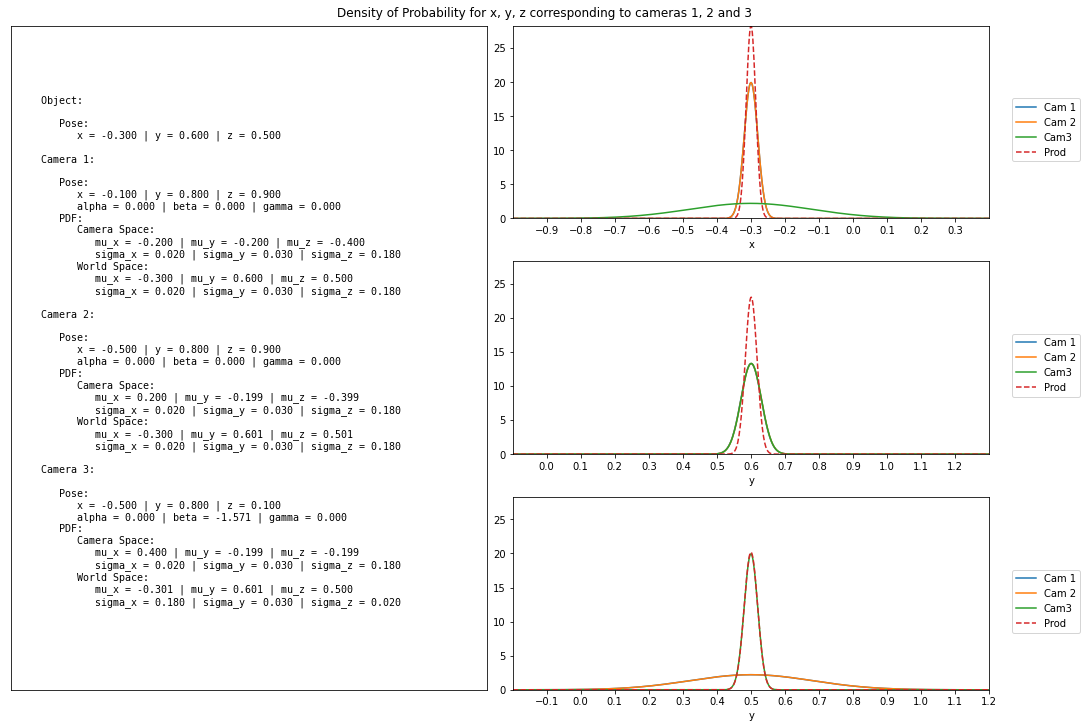

In [6]:

nb_pts = 2000

%matplotlib inline


cam_poses = np.zeros((3,6)) # 3 cameras, 6 parameters

# Cam 1
cam_poses[0,0] = -0.1 # cam1:cx
cam_poses[0,1] =  0.8 # cam1:cy
cam_poses[0,2] =  0.9 # cam1:cz
cam_poses[0,3] = (math.pi/180)*(0) # cam1:alpha
cam_poses[0,4] = (math.pi/180)*(0) # cam1:beta
cam_poses[0,5] = (math.pi/180)*(0) # cam1:gamma

# Cam 2
cam_poses[1,0] = -0.5 # cam2:cx
cam_poses[1,1] =  0.8 # cam2:cy
cam_poses[1,2] =  0.9 # cam2:cz
cam_poses[1,3] = (math.pi/180)*(0) # cam2:alpha
cam_poses[1,4] = (math.pi/180)*(0) # cam2:beta
cam_poses[1,5] = (math.pi/180)*(0) # cam2:gamma

# Cam 3
cam_poses[2,0] = -0.5 # cam3:cx
cam_poses[2,1] =  0.8 # cam3:cy
cam_poses[2,2] =  0.1 # cam3:cz
cam_poses[2,3] = (math.pi/180)*(0)# cam3:alpha
cam_poses[2,4] = (math.pi/180)*(-90)# cam3:beta
cam_poses[2,5] = (math.pi/180)*(0)# cam3:gamma

# Object's pose
ground_truth = [-0.3, 0.6, 0.5, 1]

# Max error per camera/axis ([cam1[x, y, z], cam2[x, y, z], cam2[x, y, z]])
e_per = np.array([[0.02, 0.03, 0.18], [0.02, 0.03, 0.18], [0.02, 0.03, 0.18]]) 

print("Two cameras aligned, same <mu|sigma>_<x|y|z> for all cameras")
scenario += 1

mu_c, sigma_c, mu_w, sigma_w = emulate_SNN_with_pose_transformation(nb_pts, cam_poses, ground_truth, e_per, scenario)


Close to setup upstairs, different <mu|sigma>_<x|y|z> for all cameras
The object is likely to be located at (-0.300, 0.600, 0.500)


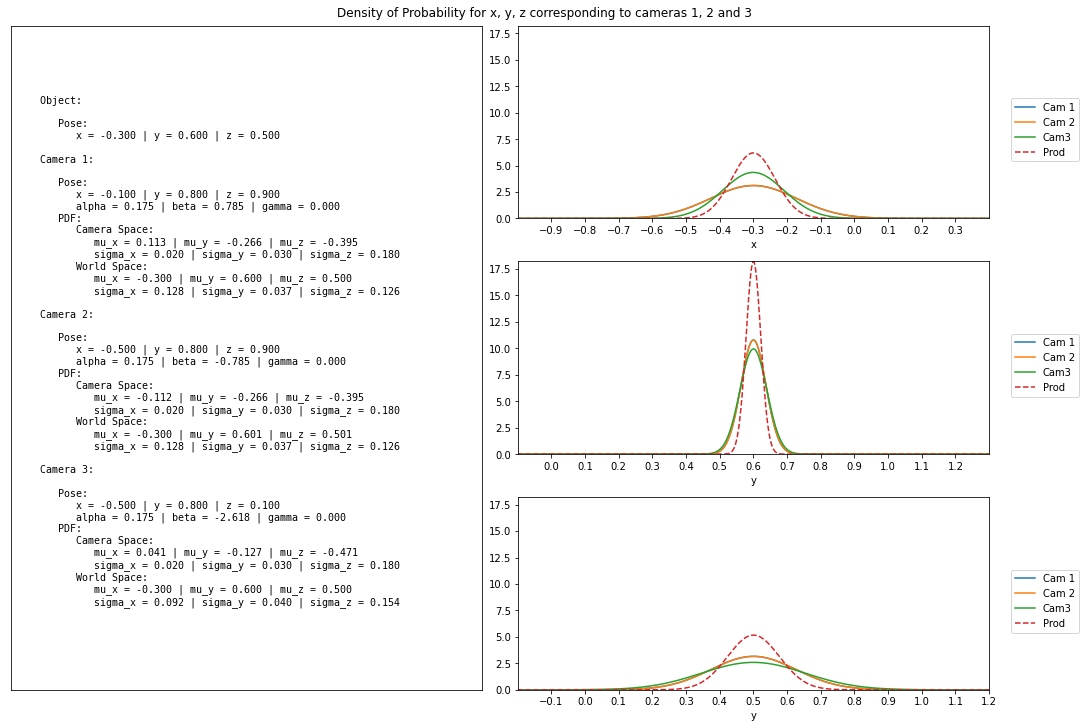

In [7]:

nb_pts = 2000

%matplotlib inline


cam_poses = np.zeros((3,6)) # 3 cameras, 6 parameters

# Cam 1
cam_poses[0,0] = -0.1 # cam1:cx
cam_poses[0,1] =  0.8 # cam1:cy
cam_poses[0,2] =  0.9 # cam1:cz
cam_poses[0,3] = (math.pi/180)*(10) # cam1:alpha
cam_poses[0,4] = (math.pi/180)*(45) # cam1:beta
cam_poses[0,5] = (math.pi/180)*(0) # cam1:gamma

# Cam 2
cam_poses[1,0] = -0.5 # cam2:cx
cam_poses[1,1] =  0.8 # cam2:cy
cam_poses[1,2] =  0.9 # cam2:cz
cam_poses[1,3] = (math.pi/180)*(10) # cam2:alpha
cam_poses[1,4] = (math.pi/180)*(-45) # cam2:beta
cam_poses[1,5] = (math.pi/180)*(0) # cam2:gamma

# Cam 3
cam_poses[2,0] = -0.5 # cam3:cx
cam_poses[2,1] =  0.8 # cam3:cy
cam_poses[2,2] =  0.1 # cam3:cz
cam_poses[2,3] = (math.pi/180)*(10)# cam3:alpha
cam_poses[2,4] = (math.pi/180)*(-150)# cam3:beta
cam_poses[2,5] = (math.pi/180)*(0)# cam3:gamma

# Object's pose
ground_truth = [-0.3, 0.6, 0.5, 1]

# Max error per camera/axis ([cam1[x, y, z], cam2[x, y, z], cam2[x, y, z]])
e_per = np.array([[0.02, 0.03, 0.18], [0.02, 0.03, 0.18], [0.02, 0.03, 0.18]]) 

print("Close to setup upstairs, different <mu|sigma>_<x|y|z> for all cameras")
scenario += 1

mu_c, sigma_c, mu_w, sigma_w = emulate_SNN_with_pose_transformation(nb_pts, cam_poses, ground_truth, e_per, scenario)


In [8]:

    
# %matplotlib notebook
# visualize_3d(200, mu_w, sigma_w)


In [9]:
# CURVE FIT TO GAUSSIAN: https://stackoverflow.com/questions/19206332/gaussian-fit-for-python/19207683